# Exercise 3: Maximum likelihood estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Ex 1: Particle decay

In this exercise, we will look numerically at the particle decay problem from Chapter 3.1.1 in the lecture notes.

A radioactive source emits $n$ unstable particles. The particles are emitted at constant speed along the $x$ axis. For each particle, indexed by  $i\in\{1,\dots,n\}$, we mark the  position $x_i$ where it decays. Our detector however only detects decays between $x_{min}$ and $x_{max}$.

The probability density of decaying at position $x$ is 
$$
\rho(x|\lambda_*)=\frac{e^{-x/\lambda_*} }{\lambda_* \left(e^{-x_{min}/\lambda_*}-e^{-x_{max}/\lambda_*}\right)}
$$
for an unknown parameter $\lambda_*$.

Given the dataset of $n$ measurements $\mathbf x=(x_1,\dots,x_n)$ our objective is to estimate $\lambda_*$ to characterize our radioactive source.


In our case we set $x_{min}=0.5,x_{max}=3,\lambda_*=4$.

In [2]:
lambda_star=4 #value of the parameter that we want to estimate. Also said "ground truth".
xmin=0.5
xmax=3

### Ex 1.1: simulating the particle decay

Your first task is to simulate this physical system, namely to generate the dataset $x_1, x_2, \dots, x_n$ given the true value $\lambda_*$.

To generate the data $\pmb x$, you will use the so called *rejection method*. 
The idea is that the p.d.f. from which we want to sample is just a truncated exponential, i.e. an exponential with scale parameter $\lambda_*$ in which we discard events in which $x < x_{\rm min}$ or $x > x_{\rm max}$.
Thus, we can just generate exponential random numbers using `np.random.exponential` one by one. 
For each sample, we check if $x_{\rm min} < x < x_{\rm max}$. If this is the case, we keep this sample, otherwise we discard it. 
We iterate the procedure until we have $n$ valid measurements.

**1.1.1**

Write a function that takes as input $n$, $\lambda_*$, $x_{\rm min}$ and $x_{\rm max}$ and generates the dataset as a lenght $n$ vector. 

In [3]:
def generate_dataset_decay(n, lambda_star, xmin, xmax):
    # returns a length n numpy array with data samples
    dataset = []
    x = np.random.exponential(scale=lambda_star, size=n)
    for i in range(n):
        if ((x[i] > xmin) and (x[i] < xmax)):
            dataset.append(x[i])
    return np.array(dataset)

**1.1.2**

Generate a dataset with $x_{min}=0.5,x_{max}=3,\lambda_*=4$. and $n=2000$ and plot its histogram using matplotlib. 
Use ```density = True``` (to have the histrogram represent a p.d.f.) and reasonable limits for the x-axis.

You will observe the truncations at $x_{min}$ and $x_{max}$ and (albeit very noisily) the exponential decay of the distribution.

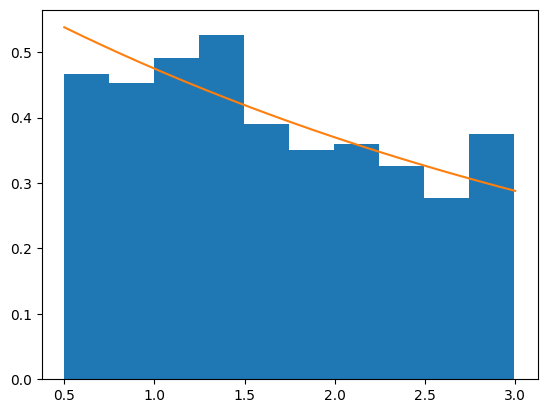

In [4]:
n = 2000
dataset_decay = generate_dataset_decay(n, lambda_star, xmin, xmax)
x = np.linspace(xmin, xmax, n)
P = lambda x: np.exp(-x/lambda_star)/(lambda_star *(np.exp(-xmin/lambda_star)-np.exp(-xmax/lambda_star)))

# plot the dataset
plt.hist(dataset_decay, density=True)
plt.plot(x, P(x))
plt.show()

### Ex 1.2: computing the maximum likelihood estimator

In the lecture notes, we derived the maximum likelihood estimator for $\lambda_*$ for a fixed interval, but the general derivation for any $x_{min},x_{max}$ is easily generalized as 
$$
\hat{\lambda} 
    = \arg\max_{\lambda} \frac{e^{-\frac{1}{\lambda n}\sum_{i=1}^n x_i} }{\lambda \left( e^{-x_{\rm min} / \lambda} - e^{-x_{\rm max} / \lambda} \right)}  
    = \arg\max_{\lambda} \mathcal{L}(\lambda)
    \, .
$$

It is easier to work with the negative normalized log-likelihood $- \frac{1}{n} \log \mathcal{L}(\lambda)$, which needs to be minimised (due to the negative sign), giving
$$
    \hat \lambda=\arg\min_\lambda \ell(\lambda)
$$
where
$$
\ell(\lambda) =
\log\lambda + \log\left(e^{-x_{min}/\lambda}-e^{-x_{max}/\lambda}\right) + \frac{1}{\lambda} \frac{1}{n}\sum_{i=1}^n x_i \, .
$$

**1.2.1**
Complete the code below to implement the $\ell(x)$ function. Notice that  ```lambda``` is a reserved keyword in python, so we use ```l``` to denote the variable $\lambda$ from the formulas in the function definition.

In [5]:
def ell(l, xmin, xmax, dataset): 
    return np.log(l) + np.log(np.exp(-xmin/l)-np.exp(-xmax/l)) + (1/(l*len(dataset)))*(sum(dataset))

**1.2.2** Use the function ```scipy.optimize.minimize``` to numerically minimize $\ell(\lambda)$ for the dataset generated in 1.1.2 and compute the maximum likelihood estimate you obtain here, $\hat{\lambda}$. Use ```0.1``` for the initial condition of the minimization. 

Hint: ```scipy.optimize.minimize``` expects a function of the form ```f(l)```, while our function is of the form ```f(l, params)```. 
This happens often.
The way to deal with this is through lambda functions, also called anonymous functions:
```
    scipy.optimize.minimize(lambda l: f(l, params), ...)
```
The keyword ```lambda``` introduces the anonymous function, ```l``` is the variable of the function, and whatever comes after the semicolon `:` is the body of the function.
You can think of the expression 
```
    lambda l: f(l, params)
```
as a shorthand for
```
    def f2(l):
        return f(l, params)
```
with the advantages of

1. not giving a name (```f2``` in the example) to a function that you will use only once.
2. Not defining a function in which we hardcode a global variable (```dataset``` in the example).

In [6]:
lambda_hat = minimize(lambda l: ell(l, xmin, xmax, dataset_decay), x0 = 0.1)
print("The estimator: ", lambda_hat.x[0])

The estimator:  4.697035203323761


**1.2.3** We want to understand the likelihood function better, and understand whether the estimate $\hat{\lambda}$ from the previous minimization is close to $\lambda^*$. 

To do so, plot the likelihood function $\ell(\lambda)$ as a function of $\lambda$ for the given dataset. 
Additionaly, plot a vertical line at the MLE estimator $x = \hat{\lambda}$ that you computed in 1.2.2, and another vertical line at the value $x = \lambda_*$.

Don't forget to put a legend!

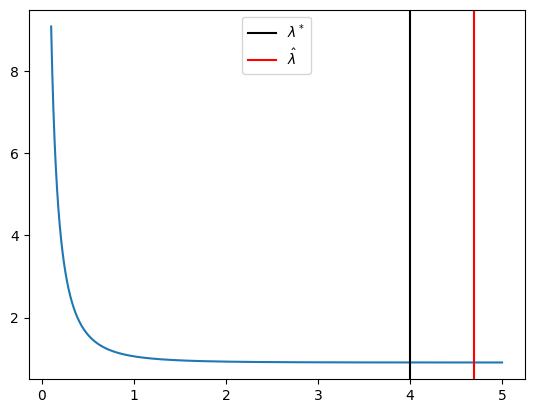

In [7]:
# plot ell and its minimum, compare to the ground truth
l_s = np.linspace(0.1, lambda_star + 1, n)
likelihood = []
for l in l_s:
    likelihood.append(ell(l, xmin, xmax, dataset_decay))

plt.plot(l_s, likelihood)
plt.axvline(lambda_star, label=r"$\lambda^*$", color="black")
plt.axvline(lambda_hat.x[0], label=r"$\hat \lambda$", color="red")
plt.legend()
plt.show()


## Ex 2: The lighthouse

A lighthouse is placed on a small island in front of the coastline. 
In a coordinate system in which the coast is the $x$ axis, and the $y$ axis points towards open sea, the island is at position $(\alpha_*, 1)$.
The lighthouse emits a series of short flashes at random intervals and hence in random directions $\theta$ (uniformly at random over the full angle of $2\pi$, because it keeps turning around).
These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not the angle from which it came.

In this exercise, we will consider the estimation task of finding the true position $\alpha_*$ of the lighthouse along the coastline, assuming that 
- the angle $\theta$ at which each light pulse is emitted is a uniformly distributed random variable on the interval $(-\pi/2, \pi/2)$ (the angle is measured with respect to the negative-vertical axis, see figure)
- a dataset of $n$ detected positions $x_1, x_2, \dots, x_n$ is given (each detection is statistically independent from the others).

![](lighthouse.png)

### Ex 2.1: simulating the lighthouse, i.e. generating the dataset of measurements

Your first task is to simulate this physical system, namely to generate the dataset $x_1, x_2, \dots, x_n$ given the true value $\alpha_*$.
To do this, we are going to generate randomly the angle $\theta_i$ at which a light pulse is emitted and we will compute the corresponding detection position $x_i$ as
$$
    x_i = \tan(\theta_i) + \alpha_* \, .
$$

**2.1.1** Write a function that takes as input $n$ and $\alpha_*$ and generates the dataset as a lenght $n$ vector. Recall that each angle is independent from the others, and uniformly distributed in the interval $(-\pi/2, \pi/2)$.

In [8]:
def generate_dataset(alpha_star, n):
    thetas = np.random.uniform(-np.pi/2, np.pi/2, n)
    return np.tan(thetas) + alpha_star 

**2.1.2** Generate a dataset with $\alpha_* = 20$ and $n=10000$ and plot its histogram. 
Set manually the binssmall enough and the y axis to log-scale to be able to interpret the diagram..
Compare to the value of  $x = \alpha_*$  using a vertical line.

Don't forget to add a legend and labels.

In [9]:
alpha_star = 20
n = 10000
x_i = generate_dataset(alpha_star, n)

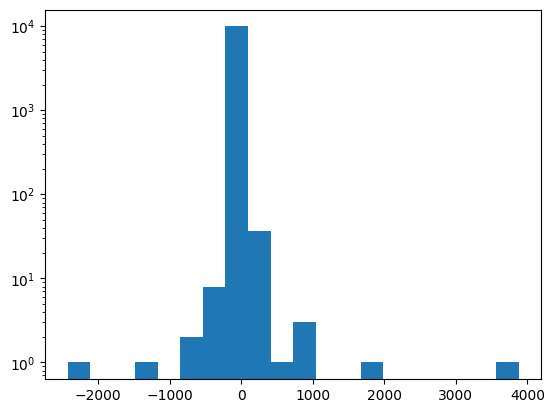

In [10]:
plt.hist(x_i, bins=20)
plt.yscale('log')
plt.show()

**2.1.3** Answer the following questions.

1. Around which value of $x$ is the histogram peaked? Motivate your answer.
2. Which values of the angle $\theta$ correspond to the extreme values (the rare outliers)?

1. Its peaked around x=0
2. The outliers correspons to the boundary

**2.1.4** Prove that the probability density function of the random variable $x(\theta)$ is given by
$$
    \rho_{x}(x | \alpha_*) = \frac{1}{\pi(1+(x - \alpha_*)^2)} \, .
$$
Hints:
1. Write down the p.d.f. of the random variable $\theta$, recalling that it is uniformly distributed on the interval $(-\pi/2, \pi/2)$.
2. Use the change of variable formula for probability density functions (see the Probability and Statistics course).

**2.1.5** 
Reproduce the plot you did in 2.1.2. 
This time, use the option ```density = True``` in the histogram (to plot probabilities instead of counts on the y axis), and compare to the p.d.f. $\rho_x$ you derived at the previous point on top of it.
Plot from $x=-100$ to $x=100$.

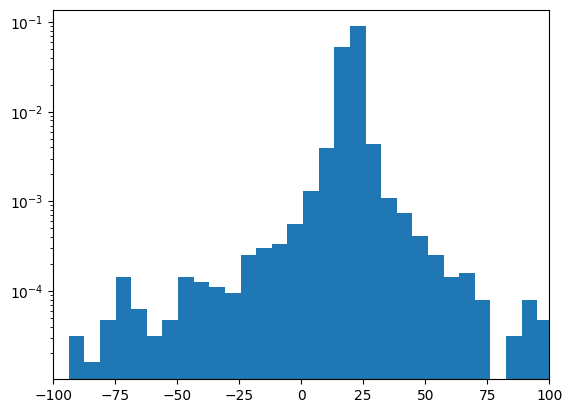

In [11]:
# plot
plt.hist(x_i, bins=1000, density=True)
plt.xlim([-100, 100])
plt.yscale('log')
plt.show()

### Ex 2.2: estimation of $\alpha_*$ through maximum likelihood

In this section, we implement the maximum likelihood estimator for $\alpha$, and use it to estimate $\alpha_*$ in the given dataset.

**2.2.1** 
Use ```np.load``` to load the file "data-lighthouse.npy" into a variable called ```dataset```. 
This will be your set of observations for this part of the exercise, in which we will try to estimate the value $\alpha_*$ used to generate the dataset. 
How many measurements does it contain?

In [20]:
# use np.load!
dataset = np.load("datalighthouse.npy")
print("Dataset contains:", len(dataset), "measurements")

Dataset contains: 50 measurements


**2.2.2** Prove that the maximum likelihood estimator (MLE) $\hat{\alpha}$ is given by
$$
\hat{\alpha} = \arg\min_{\alpha} \sum_{i=1}^n \log (1+(x_i - \alpha)^2) = \arg\min_{\alpha} f(\alpha, \{x_i\}_{i=1}^n)
$$
Hints: 
- you can follow the steps we did for the particle decay in the lecture notes, but instead for the probability density you proved before
- It is useful to maximise the log-likelihood instead of the likelihood to convert products into sums (recall that logs do not alter the position of maxima). 
- $\max[f(x)] = \min[- f(x)]$.

**2.2.3** Write a function that takes as input $\alpha$ and the dataset (a length $n$ vector) and computes $f(\alpha, \{x_i\}_{i=1}^n)$.

In [52]:
def f(a, dataset):
    sum = 0
    for x_i in dataset:
        sum += np.log(1+(x_i-a)**2)
    return sum

**2.2.4** Plot the function $f(\alpha, \{x_i\}_{i=1}^n)$ as a function of $\alpha$ and the given dataset. Plot it for $-10 < \alpha < 30$.
What can you deduce about the value of $\hat{\alpha}$ from the plot?

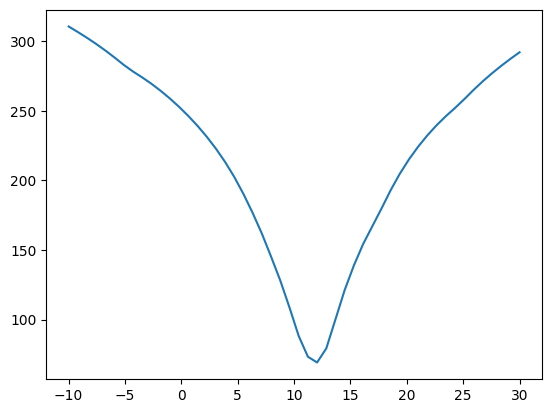

In [40]:
# 
a = np.linspace(-10, 30, len(dataset))
func = []
for a_s in a:
    func.append(f(a_s, dataset))

plt.plot(a,func)
plt.show()

**2.2.5** Minimize numerically $f$ for your dataset, e.g. with `scipy.optimize` and compute the MLE. Use ```x0=0``` for the initial condition of the minimization. Print the MLE that you obtain.

In [54]:
# minimize f
f_min = minimize(lambda a: f(a, dataset), x0 = 0.0)
f_min.x[0]

11.887987703186072

**2.2.6** 
Reproduce the plot you did in 1.2.3. 
Additionaly, plot a vertical line at  $x = \hat{\alpha}$ and add a legend. 

Are you convinced that you computed a good estimate?

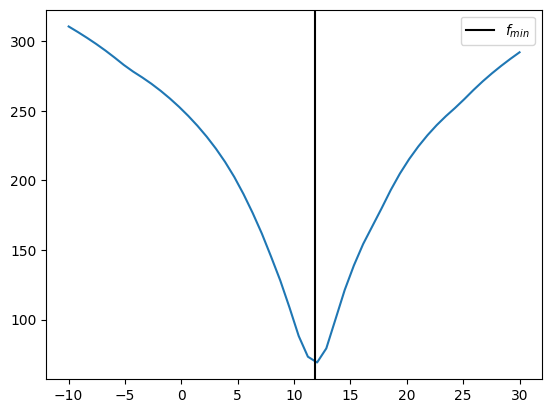

In [58]:
plt.plot(a, func)
plt.axvline(f_min.x[0], label=r"$f_{min}$", color="black")
plt.legend()
plt.show()